In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from utils import plot_auc_roc_curve

%matplotlib inline

In [36]:
# read the dataset
df = pd.read_csv(r'heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [37]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [39]:
df['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [40]:
df['Sex'].value_counts()

Sex
M    725
F    193
Name: count, dtype: int64

In [41]:
df['RestingECG'].value_counts()

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

In [42]:
df['ExerciseAngina'].value_counts()

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

In [43]:
df['ST_Slope'].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

In [44]:
# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [45]:
# Identify numerical and categorical columns
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
label_encoded_features = ['Sex', 'ExerciseAngina']
one_hot_encoded_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

In [46]:
# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('label', OrdinalEncoder(), label_encoded_features),  # Use OrdinalEncoder for binary categorical features
        ('onehot', OneHotEncoder(drop='first'), one_hot_encoded_features)  # One-hot encode other categorical features
    ])

# Apply the transformations
X_transformed = preprocessor.fit_transform(X)

# Convert to DataFrame to see the final result
# Retrieve feature names after transformation for readability
onehot_encoded_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(one_hot_encoded_features)
column_names = numerical_features + label_encoded_features + list(onehot_encoded_columns)
X_transformed = pd.DataFrame(X_transformed, columns=column_names)

# Display the preprocessed data
X_transformed.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [47]:
X_transformed.shape

(918, 14)

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, 
                                                    test_size=0.20, 
                                                    random_state=47)

In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((734, 14), (184, 14), (734,), (184,))

In [50]:

class GradientBoostingClassifierCustom(DecisionTreeRegressor):
    
    def __init__(self, n_estimators, learning_rate=0.1, criterion = "squared_error", splitter = "best", max_depth = None, 
                    min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, max_features = None, 
                    random_state = None, max_leaf_nodes = None, min_impurity_decrease = 0, ccp_alpha = 0):
        
        super().__init__(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                            min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                            random_state=random_state, max_leaf_nodes=max_leaf_nodes, 
                            min_impurity_decrease=min_impurity_decrease, ccp_alpha=ccp_alpha)
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.initial_model = None
        
    def _sigmoid(self, Z):
        return 1. / (1. + np.exp(-Z))
    
    def fit(self, X, y):
        # **Remember the loss function used is `log-loss`**
        # **That's why residuals is (y - p)**
        
        # Initialize with the log-odds of the positive class
        pos_ratio = np.mean(y)
        self.initial_model = np.log(pos_ratio / (1 - pos_ratio))
        
        # Initialize F_0(X)
        F = np.full(y.shape, self.initial_model)
        
        # Train each weak learner
        for _ in range(self.n_estimators):
            # Calculate probability and residuals
            p = self._sigmoid(F)
            residuals = y - p
            
            model = DecisionTreeRegressor(
                                max_depth=self.max_depth, 
                                criterion=self.criterion,
                                min_samples_leaf=self.min_samples_leaf,
                                max_features=self.max_features,
                                min_samples_split=self.min_samples_split
                            )
            
            model.fit(X, residuals)
            
            # Update F with the weak learner’s predictions
            update = self.learning_rate * model.predict(X)
            F += update
            
            # save the model
            self.models.append(model)
    
    def predict_proba(self, X):
        # Start with the initial prediction
        F = np.full(X.shape[0], self.initial_model)
        
        for model in self.models:
            F += self.learning_rate * model.predict(X)
        
        return self._sigmoid(F)
    
    def predict(self, X):
        # Predict probabilities and convert to class predictions
        probabilities = self.predict_proba(X)
        return (probabilities > 0.5).astype(int)

In [51]:
model1 = GradientBoostingClassifierCustom(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    criterion='friedman_mse'
)

model1.fit(X_train, y_train)

In [52]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

y_train_proba = model1.predict_proba(X_train)
y_test_proba = model1.predict_proba(X_test)

y_train_pred.shape, y_test_pred.shape, y_train_proba.shape, y_test_proba.shape

((734,), (184,), (734,), (184,))

In [53]:
# y_train_proba

In [54]:
# classification report training
print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       328
           1       0.91      0.94      0.92       406

    accuracy                           0.92       734
   macro avg       0.92      0.91      0.91       734
weighted avg       0.92      0.92      0.92       734



In [55]:
# classification report for test
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        82
           1       0.83      0.91      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



AUC Score: 0.9750878589450919


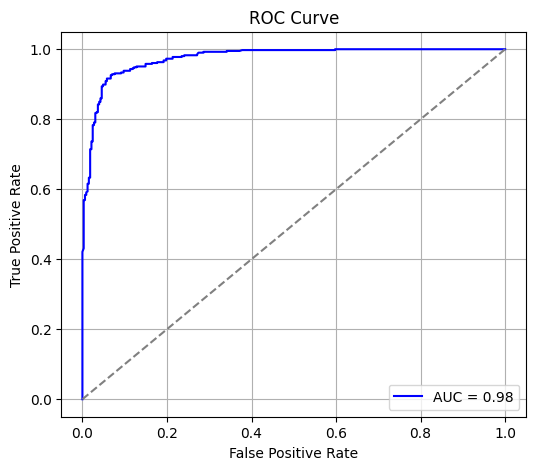

In [56]:
# train set
plot_auc_roc_curve(y=y_train, y_proba=y_train_proba)

AUC Score: 0.9031563845050214


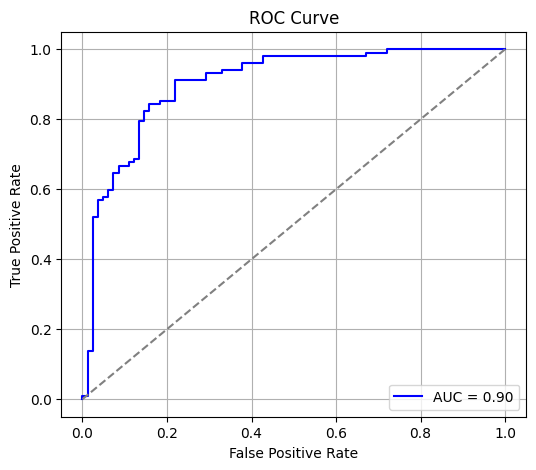

In [57]:
# test set
plot_auc_roc_curve(y=y_test, y_proba=y_test_proba)

#### **Using `sklearn.ensemble` `GradientBoostingClassifier`**

In [58]:
model2 = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    criterion='friedman_mse',
    loss='log_loss'
)

model2.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4)

In [59]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

# Extract probabilities for the positive class (class 1)
y_train_proba = model2.predict_proba(X_train)[:, 1]
y_test_proba = model2.predict_proba(X_test)[:, 1]

y_train_pred.shape, y_test_pred.shape, y_train_proba.shape, y_test_proba.shape

((734,), (184,), (734,), (184,))

In [60]:
# classification report training
print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       328
           1       0.99      1.00      0.99       406

    accuracy                           0.99       734
   macro avg       0.99      0.99      0.99       734
weighted avg       0.99      0.99      0.99       734



In [61]:
# classification report for test
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        82
           1       0.82      0.87      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184



In [62]:
# y_train_proba

AUC Score: 0.9996395530457768


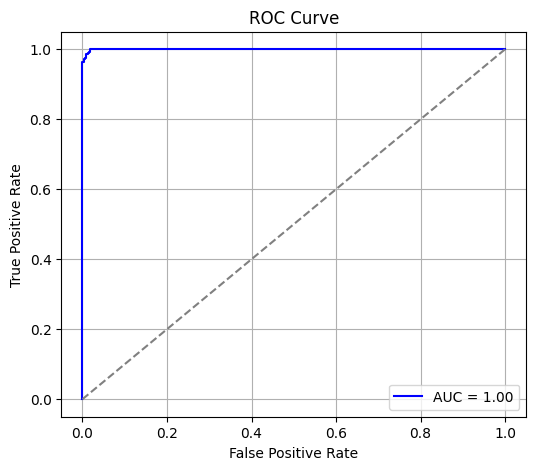

In [63]:
# train set
plot_auc_roc_curve(y=y_train, y_proba=y_train_proba)

AUC Score: 0.8897656623625059


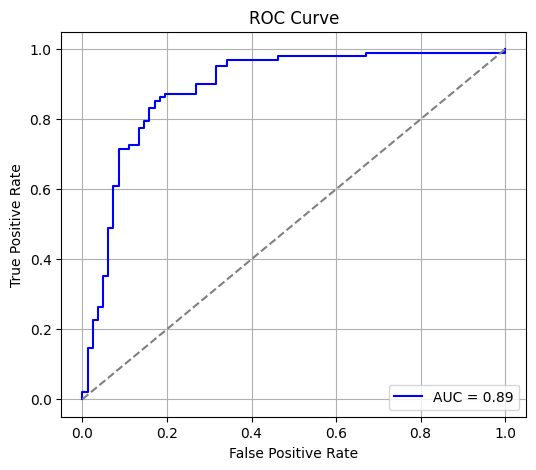

In [64]:
# test set
plot_auc_roc_curve(y=y_test, y_proba=y_test_proba)